In [11]:
import torch
import librosa
import os
import matplotlib.pyplot as plt
import csv
import pandas as pd

dataset_name = "e-gmd-v1.0.0"

df = pd.read_csv(os.path.join(dataset_name, "e-gmd-v1.0.0-clean.csv"))

train_dfs = []
valid_dfs = []
test_dfs = []

def process_row(row):
    onsets_path = row['csv_filename']
    onsets_df = pd.read_csv(os.path.join(dataset_name, onsets_path))
    onsets_df['audio_filename'] = row['audio_filename']
    split = row['split']
    if split == 'train':
        train_dfs.append(onsets_df)
    elif split == 'validation':
        valid_dfs.append(onsets_df)
    elif split == 'test':
        test_dfs.append(onsets_df)

df.apply(process_row, axis=1)

train_df = pd.concat(train_dfs, ignore_index=True)
valid_df = pd.concat(valid_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

train_df

,instrument_type,pitch,velocity,start_time,end_time,duration,audio_filename
0,snare,38,7,2.115625,2.176563,0.060937,drummer1/session1/1_funk_80_beat_4-4_1.wav
1,snare,38,10,2.176563,2.215625,0.039062,drummer1/session1/1_funk_80_beat_4-4_1.wav
2,snare,38,56,2.454688,2.556250,0.101562,drummer1/session1/1_funk_80_beat_4-4_1.wav
3,hhpedal,44,65,2.614063,2.715625,0.101562,drummer1/session1/1_funk_80_beat_4-4_1.wav
4,snare,38,48,2.628125,2.728125,0.100000,drummer1/session1/1_funk_80_beat_4-4_1.wav
...,...,...,...,...,...,...,...
10036438,kick,36,43,8.311250,8.412500,0.101250,drummer9/session1/9_rock_100_beat_4-4_8.wav
10036439,snare_rimshot,40,127,8.383750,8.483750,0.100000,drummer9/session1/9_rock_100_beat_4-4_8.wav
10036440,kick,36,65,8.660000,8.761250,0.101250,drummer9/session1/9_rock_100_beat_4-4_8.wav
10036441,crash1_edge,55,68,8.967500,9.068750,0.101250,drummer9/session1/9_rock_100_beat_4-4_8.wav


In [61]:
drum_mapping ={
          36: "kick",

          38: "snare",
          40: "snare_rimshot",
          37: "snare_xstick",
          39: "clap",

          48: "tom1",
          50: "tom1_rim",
          45: "tom2",
          47: "tom2_rim",
          43: "tom3",
          58: "tom3_rim",

          46: "hhopen_bow",
          26: "hhopen_edge",
          42: "hhclosed_bow",
          22: "hhclosed_edge",
          44: "hhpedal",
          54: "tambourine",
          
          49: "crash1_bow",
          55: "crash1_edge",
          57: "crash2_bow",
          52: "crash2_edge",

          51: "ride_bow",
          59: "ride_edge",
          
          53: "ride_bell",
          56: "cowbell",
}

# bass_drums = ["kick"]
# snares = ["snare", "snare_rimshot", "snare_xstick", "clap"]
# toms = ["tom1", "tom1_rim", "tom2", "tom2_rim", "tom3", "tom3_rim"]
# hihats = ["hhopen_bow", "hhopen_edge", "hhclosed_bow", "hhclosed_edge", "hhpedal"]
# cymbals = ["crash1_bow", "crash1_edge", "crash2_bow", "crash2_edge"]
# rides = ["ride_bow", "ride_edge", "ride_bell"]
# percussion = ["tambourine", "cowbell"]

In [101]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np

# Define the dataset class
class DrumDataset(Dataset):
    def __init__(self, df, master_csv_path, transform, window_size=8192):
        self.df = df
        self.master_df = pd.read_csv(master_csv_path)
        self.window_size = window_size
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load the onset time, label, and track name for the given index
        row = self.df.iloc[idx]
        onset_time = (row['start_time']+row['end_time'])/2
        drum_tensor = torch.zeros(len(drum_mapping))
        index = list(drum_mapping.values()).index(row['instrument_type'])
        drum_tensor[index] = 1
        track_filename = row['audio_filename']

        audio, sr = torchaudio.load(os.path.join(dataset_name, track_filename), format="mp3")
        onset_window = audio[:, int(onset_time*sr)-self.window_size//2:int(onset_time*sr)+self.window_size//2]
        if onset_window.shape[0] == 2:
            onset_window = torch.mean(onset_window, dim=0, keepdim=True)
        padding_size = max(0, self.window_size - onset_window.size(-1))
        if padding_size > 0:
            padding = (padding_size // 2, padding_size - padding_size // 2)  # divide the padding equally before and after the window
            onset_window = torch.nn.functional.pad(onset_window, padding, "constant", 0)

        spec = self.transform(onset_window[0])
        return spec, drum_tensor

transform = transforms.Compose([
    # transforms.RandomApply([
    #     torchaudio.transforms.PitchShift(sample_rate=44100, n_steps=random.uniform(-1, 1)),
    #     torchaudio.transforms.TimeStretch(hop_length=64, fixed_rate=random.uniform(0.8, 1.2)),
    # ], p=0.5),
    transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                sample_rate=44100,
                n_fft=2048,
                hop_length=64,
                n_mels=128
            )(x),
            torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': 2048, 'hop_length': 64, 'n_mels': 128})(x)
        ], dim=0)),
    transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB()(x[0]),
            x[0],
            x[1]
        ], dim=0))
])

valid_dataset = DrumDataset(valid_df, "HeartsOnFire-v.1.0.0/master.csv", transform)
train_dataset = DrumDataset(train_df, "HeartsOnFire-v.1.0.0/master.csv", transform)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])


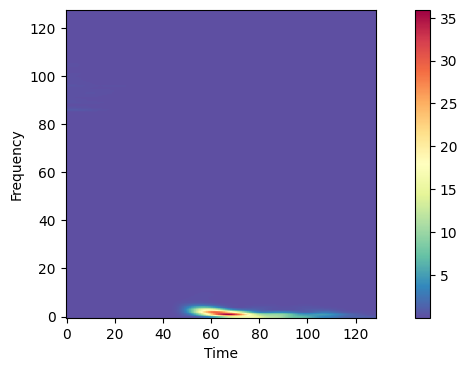

In [111]:
a, x = train_dataset.__getitem__(random.randint(1, len(train_df)))
specgram = a[1].squeeze(0).numpy()
print(x)

# Display the spectrogram using matplotlib
plt.figure(figsize=(10, 4))
plt.imshow(specgram, cmap='Spectral_r', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

In [113]:
# Define the neural network architecture
import torch.nn as nn

class DrumCNN(nn.Module):
    def __init__(self):
        super(DrumCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(256, len(drum_mapping))
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x
    
x = x.view(x.size(0), -1)

def accuracy(outputs, labels, threshold=0.5):
    with torch.no_grad():
        preds = (outputs > threshold).float()
        correct = (preds == labels).sum(dim=1).eq(labels.shape[1]).sum().item()
        total = labels.shape[0]
        return 100 * correct / total

# Create data loaders for training and validation sets
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize the neural network and optimizer
device = torch.device('cuda')
model = DrumCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Train the model
n_epochs = 10
for epoch in range(n_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_acc += accuracy(outputs, labels) * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            valid_acc += accuracy(outputs, labels) * inputs.size(0)
        valid_loss /= len(valid_loader.dataset)
        valid_acc /= len(valid_loader.dataset)
    
    # Update the learning rate based on the validation loss
    scheduler.step(valid_loss)
    
    # Print the training and validation loss and accuracy
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

KeyboardInterrupt: 